In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

df = pd.read_csv('credit_dataset.csv')

/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/1420131817.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('credit_dataset.csv')


In [3]:
print(f"Dimensiones del dataset: {df.shape}")

Dimensiones del dataset: (466285, 75)


In [4]:
print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
   Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi

In [7]:
print("\nTipos de datos:")
print(df.dtypes)


Tipos de datos:
Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object


In [8]:
print("\nValores únicos en loan_status:")
print(df['loan_status'].value_counts())


Valores únicos en loan_status:
loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64


## Manejo de datos faltantes

In [12]:
null_counts = df.isnull().sum()
missing_pct = (null_counts / len(df) * 100)

print("\nPorcentaje de valores faltantes por columna:")
missing_df = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores Faltantes': null_counts.values,
    'Porcentaje (%)': missing_pct.values
})
print(missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Porcentaje (%)', ascending=False))

high_missing_cols = missing_pct[missing_pct > 50].index.tolist()
df = df.drop(columns=high_missing_cols)
print(f"\nColumnas eliminadas pro alto porcentaje de valores faltantes: {high_missing_cols}")


Porcentaje de valores faltantes por columna:
                        Columna  Valores Faltantes  Porcentaje (%)
55                    dti_joint             466285      100.000000
54             annual_inc_joint             466285      100.000000
73                  total_cu_tl             466285      100.000000
72                       inq_fi             466285      100.000000
70                     all_util             466285      100.000000
69                   max_bal_bc             466285      100.000000
68                  open_rv_24m             466285      100.000000
67                  open_rv_12m             466285      100.000000
66                      il_util             466285      100.000000
65                 total_bal_il             466285      100.000000
64           mths_since_rcnt_il             466285      100.000000
63                  open_il_24m             466285      100.000000
62                  open_il_12m             466285      100.000000
61              

## Preparación del Target


Distribución de la variable objetivo (PD):
PD
0.0    184739
1.0     12096
Name: count, dtype: int64
Proporción de defaults: 0.0615


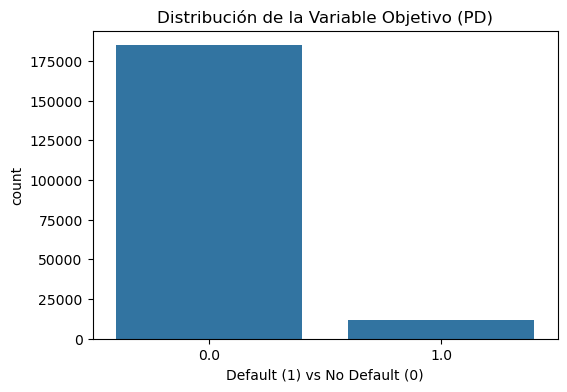

In [13]:
def map_target(status):
    if status == 'Fully Paid':
        return 0
    elif status in ['Default', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']:
        return 1
    else:
        return np.nan

df['PD'] = df['loan_status'].apply(map_target)

df = df.dropna(subset=['PD'])

print("\nDistribución de la variable objetivo (PD):")
pd_counts = df['PD'].value_counts()
print(pd_counts)
print(f"Proporción de defaults: {pd_counts[1]/len(df):.4f}")

plt.figure(figsize=(6,4))
sns.countplot(x='PD', data=df)
plt.title('Distribución de la Variable Objetivo (PD)')
plt.xlabel('Default (1) vs No Default (0)')
plt.show()

## Selección de Características y Limpieza

In [18]:
columns_to_drop = [
    'Unnamed: 0', 'id', 'member_id', 'url', 
    'title', 'pymnt_plan', 'next_pymnt_d', 'loan_status'
]

for col in df.columns:
    if df[col].nunique() == 1:
        columns_to_drop.append(col)

df_model = df.drop(columns=columns_to_drop)

print(f"\nTotal de columnas seleccionadas: {len(df_model.columns)}")


Total de columnas seleccionadas: 43


## Detección y Tratamiento de Outliers

In [19]:
numeric_cols = df_model.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'PD']

def handle_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    if outliers > 0:
        df[col + '_capped'] = df[col].copy()
        df.loc[df[col] < lower_bound, col + '_capped'] = lower_bound
        df.loc[df[col] > upper_bound, col + '_capped'] = upper_bound
        return True, outliers, col + '_capped'

    return False, 0, col

columns_with_outliers = []
for col in numeric_cols:
    has_outliers, count, new_col = handle_outliers(df_model, col)
    if has_outliers:
        columns_with_outliers.append((col, count, new_col))

print("\nColumnas con outliers tratados:")
for col, count, new_col in columns_with_outliers:
    print(f"{col}: {count} outliers detectados, nueva columna: {new_col}")


Columnas con outliers tratados:
loan_amnt: 5871 outliers detectados, nueva columna: loan_amnt_capped
funded_amnt: 5789 outliers detectados, nueva columna: funded_amnt_capped
funded_amnt_inv: 5711 outliers detectados, nueva columna: funded_amnt_inv_capped
int_rate: 1018 outliers detectados, nueva columna: int_rate_capped
installment: 5577 outliers detectados, nueva columna: installment_capped
annual_inc: 7921 outliers detectados, nueva columna: annual_inc_capped
dti: 211 outliers detectados, nueva columna: dti_capped
delinq_2yrs: 31396 outliers detectados, nueva columna: delinq_2yrs_capped
inq_last_6mths: 16458 outliers detectados, nueva columna: inq_last_6mths_capped
open_acc: 4567 outliers detectados, nueva columna: open_acc_capped
pub_rec: 22859 outliers detectados, nueva columna: pub_rec_capped
revol_bal: 10014 outliers detectados, nueva columna: revol_bal_capped
revol_util: 8 outliers detectados, nueva columna: revol_util_capped
total_acc: 2846 outliers detectados, nueva columna: 

## Ingeniería de Características - División en Bins

In [21]:
def equal_frequency_binning(df, col, n_bins=10):
    df[col + '_bin'] = pd.qcut(df[col], q=n_bins, duplicates='drop')
    return col + '_bin'

numeric_features = df_model.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col != 'PD' and not col.endswith('_capped')]

binned_features = []
for feature in numeric_features:
    try:
        binned_feature = equal_frequency_binning(df_model, feature)
        binned_features.append(binned_feature)
    except:
        print(f"No se pudo aplicar binning a {feature}")

print(f"\nSe crearon {len(binned_features)} características binned")


Se crearon 27 características binned


## Cálculo de WoE e IV


Information Value para loan_amnt_bin: 0.1053 - Predictor medio

Information Value para funded_amnt_bin: 0.1080 - Predictor medio

Information Value para funded_amnt_inv_bin: 0.1145 - Predictor medio

Information Value para int_rate_bin: 0.4200 - Predictor fuerte

Information Value para installment_bin: 0.0930 - Predictor débil

Information Value para annual_inc_bin: 0.0084 - No predictiva

Information Value para dti_bin: 0.1464 - Predictor medio

Information Value para delinq_2yrs_bin: 0.0270 - Predictor débil

Information Value para inq_last_6mths_bin: 0.0003 - No predictiva

Information Value para open_acc_bin: 0.0337 - Predictor débil

Information Value para pub_rec_bin: 0.0089 - No predictiva

Information Value para revol_bal_bin: 0.0135 - No predictiva

Information Value para revol_util_bin: 0.0926 - Predictor débil

Information Value para total_acc_bin: 0.0022 - No predictiva

Information Value para out_prncp_bin: 0.0000 - No predictiva

Information Value para out_prncp_inv_bin:

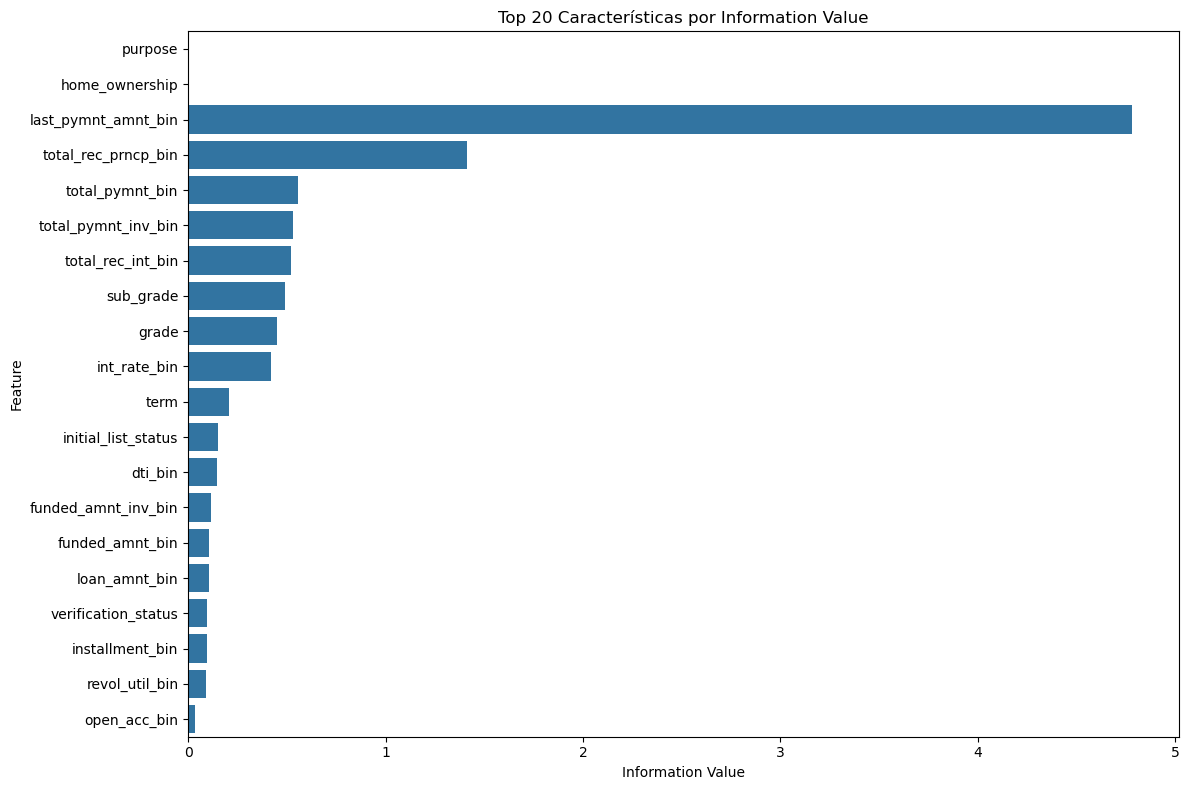

In [23]:
def calculate_woe_iv(df, feature, target='PD'):
    """
    Calcula Weight of Evidence (WoE) e Information Value (IV) para una característica.

    Para WoE:
    - WoE > 0: Mayor proporción de buenos que de malos préstamos (menor riesgo)
    - WoE < 0: Mayor proporción de malos que de buenos préstamos (mayor riesgo)
    """
    df = df.copy()

    cross_tab = pd.crosstab(df[feature], df[target])

    # Calcular distribuciones
    dist_good = cross_tab[0] / cross_tab[0].sum()
    dist_bad = cross_tab[1] / cross_tab[1].sum()

    # Calcular WoE e IV
    woe = np.log(dist_good / dist_bad)
    iv = (dist_good - dist_bad) * woe

    # Total IV
    iv_total = iv.sum()

    # Crear DataFrame con resultados:
    result = pd.DataFrame({
        'Count_Good': cross_tab[0],
        'Count_Bad': cross_tab[1],
        'Dist_Good': dist_good,
        'Dist_Bad': dist_bad,
        'WoE': woe,
        'IV': iv
    })

    # Interpretación de IV
    iv_interpretation = ""
    if iv_total < 0.02:
        iv_interpretation = "No predictiva"
    elif iv_total < 0.1:
        iv_interpretation = "Predictor débil"
    elif iv_total < 0.3:
        iv_interpretation = "Predictor medio"
    elif iv_total < 0.5:
        iv_interpretation = "Predictor fuerte"
    else:
        iv_interpretation = "Predictor muy fuerte (posible problema)"

    print(f"\nInformation Value para {feature}: {iv_total:.4f} - {iv_interpretation}")

    return result, iv_total

# Calcular WoE e IV para cada característica binned
woe_tables = {}
iv_values = {}

for feature in binned_features:
    woe_table, iv = calculate_woe_iv(df_model, feature)
    woe_tables[feature] = woe_table
    iv_values[feature] = iv

cat_features = df_model.select_dtypes(include=['object']).columns
for feature in cat_features:
    if df_model[feature].nunique() < 50:
        try:
            woe_table, iv = calculate_woe_iv(df_model, feature)
            woe_tables[feature] = woe_table
            iv_values[feature] = iv
        except:
            print(f"No se pudo calcular WoE para {feature}")

iv_df = pd.DataFrame({
    'Feature': list(iv_values.keys()),
    'IV': list(iv_values.values())
})
iv_df = iv_df.sort_values('IV', ascending=False)

print("\nRanking de características por Information Value:")
print(iv_df)

plt.figure(figsize=(12,8))
sns.barplot(x='IV', y='Feature', data=iv_df.head(20))
plt.title('Top 20 Características por Information Value')
plt.xlabel('Information Value')
plt.tight_layout()
plt.show()

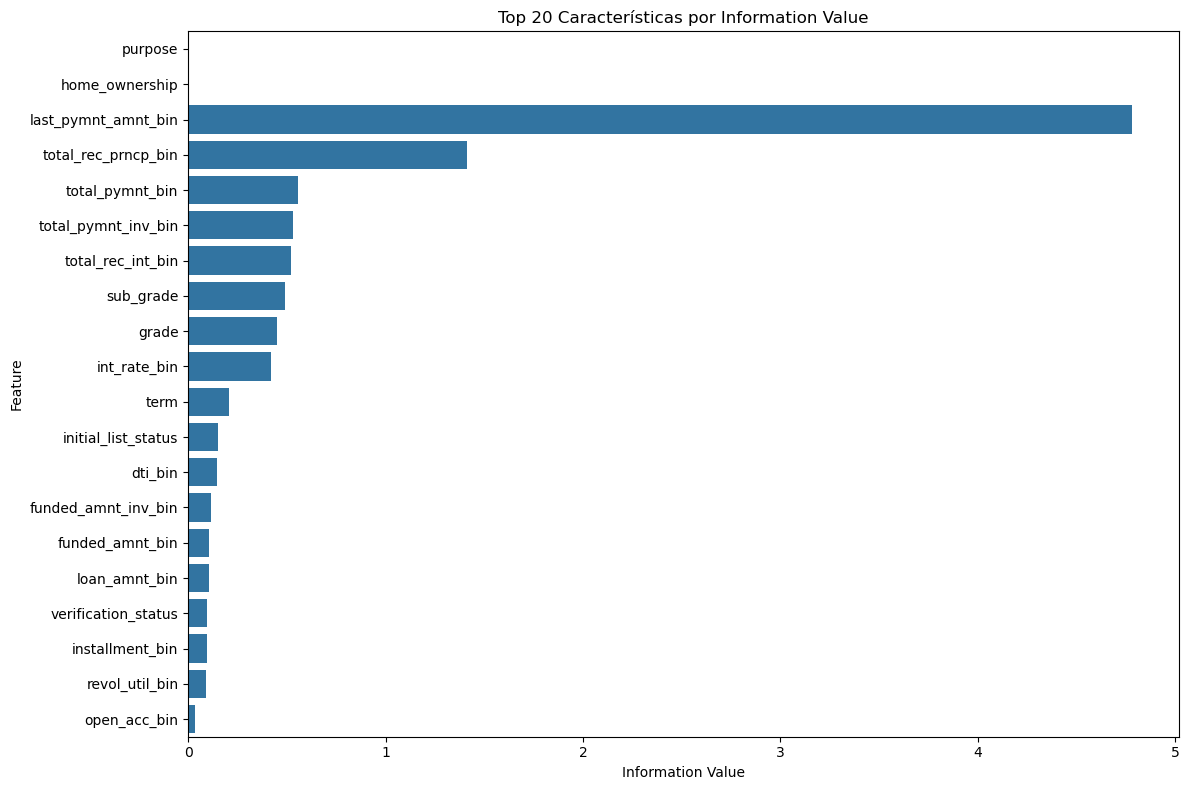

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(x='IV', y='Feature', data=iv_df.head(20))
plt.title('Top 20 Características por Information Value')
plt.xlabel('Information Value')
plt.tight_layout()
plt.show()

## Transformación de Variables usando WoE

In [27]:
# Función para transformar una característica usando su tabla WoE
#def transform_feature_with_woe(df, feature, woe_table):
#    df = df.copy()
    
    # Crear un diccionario de mapeo {categoría: WoE}
#    woe_dict = woe_table['WoE'].to_dict()
    
    # Aplicar la transformación
#    df[feature + '_woe'] = df[feature].map(woe_dict)
    
    # Si hay valores NaN después del mapeo, asignar el WoE promedio
#    if df[feature + '_woe'].isnull().sum() > 0:
#        mean_woe = woe_table['WoE'].mean()
#        df[feature + '_woe'].fillna(mean_woe, inplace=True)
#    
#    return df[feature + '_woe']

# Seleccionar características relevantes basadas en IV (IV > 0.02)
#selected_features = iv_df[iv_df['IV'] > 0.02]['Feature'].tolist()
#print(f"\nSe seleccionaron {len(selected_features)} características con IV > 0.02")

# Aplicar transformación WoE a las características seleccionadas
#woe_features = []
#for feature in selected_features:
#    feature_woe = transform_feature_with_woe(df_model, feature, woe_tables[feature])
#    df_model[feature + '_woe'] = feature_woe
#    woe_features.append(feature + '_woe')
#
#print(f"Se crearon {len(woe_features)} características WoE")

In [28]:
# Seleccionar características relevantes basadas en IV (IV > 0.02)
selected_features = iv_df[iv_df['IV'] > 0.02]['Feature'].tolist()
print(f"\nSe seleccionaron {len(selected_features)} características con IV > 0.02")

# Función revisada para transformar características con WoE
def transform_feature_with_woe(df, feature, woe_table):
    df = df.copy()
    
    # Convertir a string si es categórica para evitar problemas
    if pd.api.types.is_categorical_dtype(df[feature]):
        feature_values = df[feature].astype(str)
    else:
        feature_values = df[feature]
        
    # Crear un diccionario de mapeo {categoría: WoE}
    woe_dict = woe_table['WoE'].to_dict()
    
    # Aplicar la transformación
    woe_values = feature_values.map(woe_dict)
    
    # Si hay valores NaN después del mapeo, asignar el WoE promedio
    if woe_values.isnull().any():
        mean_woe = woe_table['WoE'].mean()
        woe_values = woe_values.fillna(mean_woe)  # Sin inplace=True
    
    return woe_values

# Aplicar transformación WoE a las características seleccionadas
woe_features = []
for feature in selected_features:
    try:
        # Obtener el valor WoE
        feature_woe = transform_feature_with_woe(df_model, feature, woe_tables[feature])
        
        # Asignar al dataframe
        df_model[feature + '_woe'] = feature_woe
        
        # Agregar a la lista de características WoE
        woe_features.append(feature + '_woe')
        print(f"Transformada: {feature}")
    except Exception as e:
        print(f"Error al transformar {feature}: {str(e)}")

print(f"Se crearon {len(woe_features)} características WoE")


Se seleccionaron 23 características con IV > 0.02
Transformada: purpose
Transformada: home_ownership


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: last_pymnt_amnt_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: total_rec_prncp_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: total_pymnt_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: total_pymnt_inv_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: total_rec_int_bin
Transformada: sub_grade
Transformada: grade


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: int_rate_bin
Transformada: term
Transformada: initial_list_status


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: dti_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: funded_amnt_inv_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: funded_amnt_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: loan_amnt_bin
Transformada: verification_status


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):
/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: installment_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: revol_util_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: open_acc_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: delinq_2yrs_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: total_rev_hi_lim_bin


/var/folders/30/bqhvgy251t71zrd5hbqbfxlc0000gn/T/ipykernel_72854/3469820014.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[feature]):


Transformada: tot_cur_bal_bin
Se crearon 23 características WoE


## División de Datos en Train-Test Validation

In [31]:
X = df_model[woe_features]
y = df_model['PD']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} registros ({X_train.shape[0]/X.shape[0]:.2%})")
print(f"Conjunto de validación: {X_val.shape[0]} registros ({X_val.shape[0]/X.shape[0]:.2%})")
print(f"Conjunto de prueba: {X_test.shape[0]} registros ({X_test.shape[0]/X.shape[0]:.2%})")


Conjunto de entrenamiento: 137784 registros (70.00%)
Conjunto de validación: 29525 registros (15.00%)
Conjunto de prueba: 29526 registros (15.00%)


## Entrenamiento del Modelo de Regresión Logística

In [34]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)

print("Columnas con NaN en X_train:", X_train.columns[X_train.isna().any()].tolist())
print("Cantidad de NaN por columna en X_train:")
print(X_train.isna().sum()[X_train.isna().sum() > 0])

Columnas con NaN en X_train: ['purpose_woe', 'home_ownership_woe']
Cantidad de NaN por columna en X_train:
purpose_woe           196
home_ownership_woe    114
dtype: int64


In [35]:
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())

model = LogisticRegression(random_state=1, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]
print("\nResultados en conjunto de validación:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_val_pred))
print("\nInforme de clasificación:")
print(classification_report(y_val, y_val_pred))
print(f"\nAUC-ROC: {roc_auc_score(y_val, y_val_prob):.4f}")


Resultados en conjunto de validación:

Matriz de confusión:
[[27711     0]
 [ 1814     0]]

Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     27711
         1.0       0.00      0.00      0.00      1814

    accuracy                           0.94     29525
   macro avg       0.47      0.50      0.48     29525
weighted avg       0.88      0.94      0.91     29525


AUC-ROC: 0.7185


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Análisis de Coeficientes

In [36]:
coefficients = pd.DataFrame({
    'Feature': woe_features,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0]),
    'Odds_Ratio': np.exp(model.coef_[0]) 
})

coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\nCoeficientes del modelo:")
print(coefficients)

print("\nInterpretación de los coeficientes:")
print("- Un coeficiente positivo indica que cuando el WoE aumenta (menor riesgo), la probabilidad de default disminuye")
print("- Un coeficiente negativo indica que cuando el WoE aumenta (menor riesgo), la probabilidad de default aumenta")
print("- Odds Ratio > 1: El factor aumenta las probabilidades de no default")
print("- Odds Ratio < 1: El factor disminuye las probabilidades de no default")


Coeficientes del modelo:
                     Feature  Coefficient  Abs_Coefficient  Odds_Ratio
1         home_ownership_woe    -1.216565         1.216565    0.296246
11   initial_list_status_woe    -0.870259         0.870259    0.418843
7              sub_grade_woe    -0.805661         0.805661    0.446793
2    last_pymnt_amnt_bin_woe    -0.739451         0.739451    0.477376
0                purpose_woe    -0.679641         0.679641    0.506799
16   verification_status_woe    -0.522864         0.522864    0.592820
10                  term_woe    -0.327927         0.327927    0.720416
3    total_rec_prncp_bin_woe    -0.165808         0.165808    0.847209
20       delinq_2yrs_bin_woe     0.069448         0.069448    1.071916
6      total_rec_int_bin_woe    -0.061461         0.061461    0.940390
4        total_pymnt_bin_woe    -0.061171         0.061171    0.940662
5    total_pymnt_inv_bin_woe    -0.059014         0.059014    0.942694
9           int_rate_bin_woe    -0.043813         0

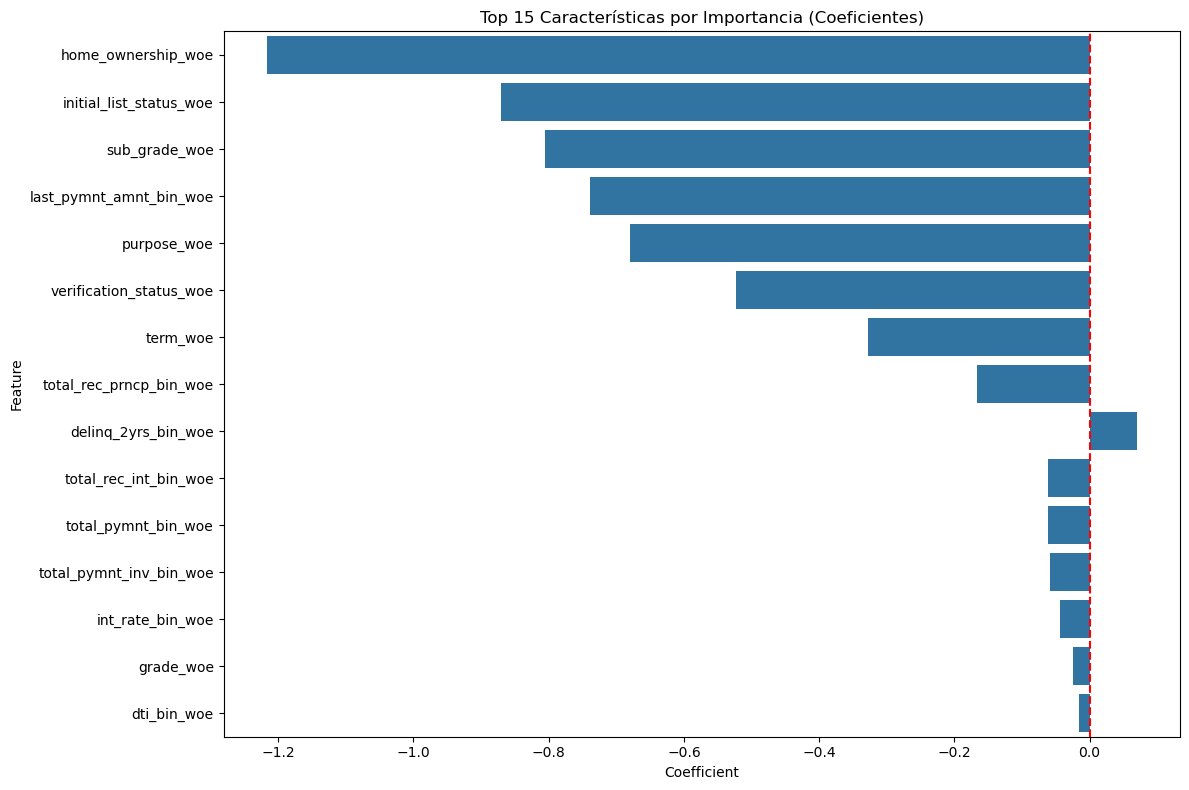

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(15))
plt.title('Top 15 Características por Importancia (Coeficientes)')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

## Evaluación Final en Conjunto de Test

In [41]:
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(X_train.median())

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print("\nResultados en conjunto de prueba:")
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_test_pred))

print("\nInforme de clasificación:")
print(classification_report(y_test, y_test_pred))

print(f"\nAUC-ROC: {roc_auc_score(y_test, y_test_prob):.4f}")


Resultados en conjunto de prueba:

Matriz de confusión:
[[27711     0]
 [ 1815     0]]

Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     27711
         1.0       0.00      0.00      0.00      1815

    accuracy                           0.94     29526
   macro avg       0.47      0.50      0.48     29526
weighted avg       0.88      0.94      0.91     29526


AUC-ROC: 0.7236


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


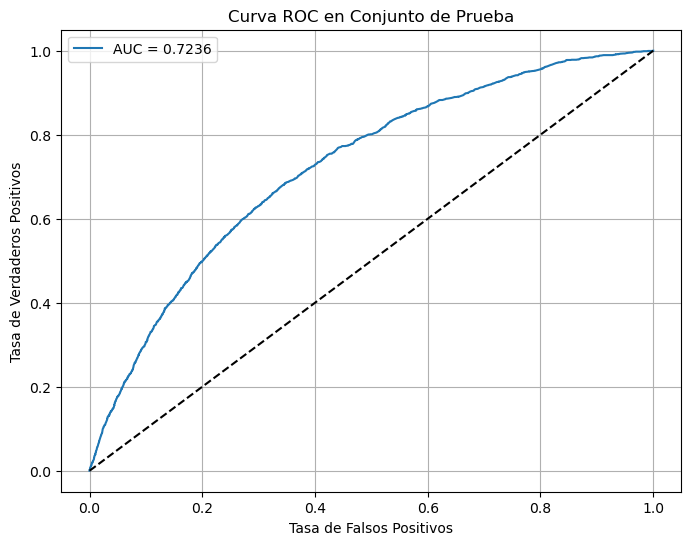

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_test_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC en Conjunto de Prueba')
plt.legend()
plt.grid(True)
plt.show()

## Creación del Scorecard

In [45]:
PDO = 20
score_odds = 20
base_score = 700
factor = PDO / np.log(2)
offset = base_score - factor * np.log(score_odds)
print(f"\nParámetros del Scorecard:")
print(f"PDO: {PDO}")
print(f"Odds para score {base_score}: {score_odds}:1")
print(f"Factor: {factor:.4f}")
print(f"Offset: {offset:.4f}")

scorecard = []

for feature in woe_features:
    coef = coefficients[coefficients['Feature'] == feature]['Coefficient'].values[0]
    orig_feature = feature.replace('_woe', '')
    woe_table = woe_tables[orig_feature].copy()

    woe_table['WoE'] = woe_table['WoE'].replace([np.inf, -np.inf], np.nan)
    woe_table['WoE'] = woe_table['WoE'].fillna(woe_table['WoE'].mean() if not np.isnan(woe_table['WoE'].mean()) else 0)

    woe_table['Points'] = -factor * coef * woe_table['WoE']

    woe_table['Points'] = woe_table['Points'].replace([np.inf, -np.inf], np.nan)
    woe_table['Points'] = woe_table['Points'].fillna(0)

    woe_table['Points'] = np.round(woe_table['Points']).astype(int)
    
    for bin_value, row in woe_table.iterrows():
        scorecard.append({
            'Feature': orig_feature,
            'Bin': bin_value,
            'WoE': row['WoE'],
            'Points': row['Points']
        })

scorecard_df = pd.DataFrame(scorecard)

if 'Intercept' in coefficients['Feature'].values:
    intercept_coef = coefficients[coefficients['Feature'] == 'Intercept']['Coefficient'].values[0]
else:
    intercept_coef = model.intercept_[0] if hasattr(model, 'intercept_') else 0

intercept_points = np.round(-factor * intercept_coef).astype(int)
intercept_row = pd.DataFrame([{
    'Feature': 'Intercept',
    'Bin': 'Intercept',
    'WoE': 1.0,
    'Points': intercept_points
}])

scorecard_df = pd.concat([intercept_row, scorecard_df], ignore_index=True)

print("\nScorecard completo:")
print(scorecard_df.sort_values(['Feature', 'Bin']))

def calculate_credit_score(client_data, scorecard_df, offset):
    score = offset
    for _, row in scorecard_df.iterrows():
        if row['Feature'] == 'Intercept':
            score += row['Points']
        else:
            if row['Feature'] in client_data.index and client_data[row['Feature']] == row['Bin']:
                score += row['Points']
    return score

print("\nEjemplo de scores para los primeros 5 clientes:")
for i in range(5):
    client_data = df_model.iloc[i]
    score = calculate_credit_score(client_data, scorecard_df, offset)
    print(f"Cliente {i+1}: Score = {score}")


Parámetros del Scorecard:
PDO: 20
Odds para score 700: 20:1
Factor: 28.8539
Offset: 613.5614

Scorecard completo:
                  Feature                   Bin       WoE  Points
0               Intercept             Intercept  1.000000     7.0
200       delinq_2yrs_bin         (-0.001, 1.0]  0.043210     0.0
201       delinq_2yrs_bin           (1.0, 29.0] -0.625522     1.0
127               dti_bin        (-0.001, 6.22]  0.699991     0.0
128               dti_bin          (6.22, 9.18]  0.321010     0.0
..                    ...                   ...       ...     ...
210  total_rev_hi_lim_bin    (41600.0, 57300.0]  0.175769     0.0
211  total_rev_hi_lim_bin  (57300.0, 2013133.0]  0.372458     0.0
167   verification_status          Not Verified  0.441095     7.0
168   verification_status       Source Verified -0.327800    -5.0
169   verification_status              Verified -0.063772    -1.0

[222 rows x 4 columns]

Ejemplo de scores para los primeros 5 clientes:
Cliente 1: Score = 6